In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from sqlalchemy import func
from sqlalchemy import text

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Examine the measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b804a6fb70>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

## Precipitation Analysis
Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database

# Find the latest date
late_date = []
for date in session.query(Measurement.date).order_by(Measurement.date.desc()).first():
    late_date.append(date)

# Spliting the date into year, month, day
latest_date = late_date[0]
latest = latest_date.split('-')
year = int(latest[0])
month = int(latest[1])
day = int(latest[2])

# Find 1 year of data 
year_ago = dt.date(year, month, day) - dt.timedelta(days=365)

print(f'Query the following date range: {year_ago} to {latest_date}')

Query the following date range: 2016-08-23 to 2017-08-23


In [12]:
# Perform a query to retrieve the date and precipitation scores (Sorting the dataframe by date)

stmt = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago, latest_date)).\
    order_by(Measurement.date.desc()).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df2=pd.read_sql(stmt, session.bind)
df2
precip = df2.set_index("date")
precip

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


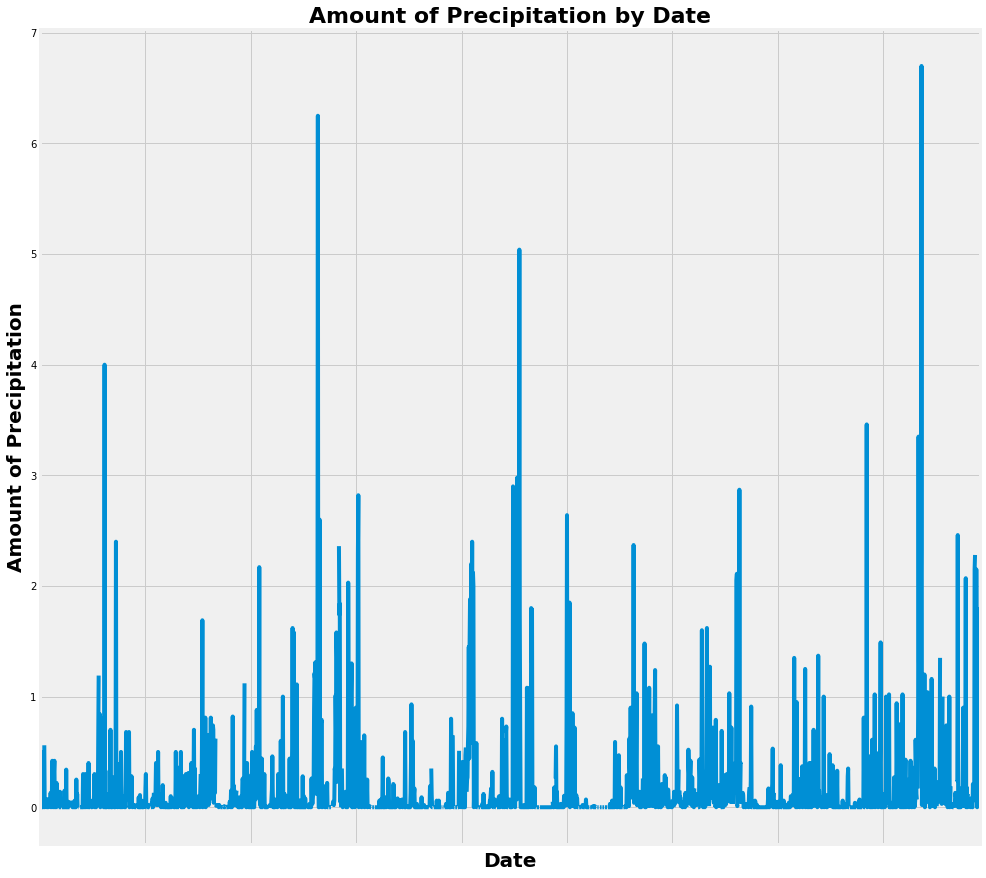

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

# Generating graph
ax = precip.plot(figsize=(15, 15), legend=False)

# Editing tick marks
ax.set_xticklabels('')


# Adding title, labels to graph
ax.set_title("Amount of Precipitation by Date", fontsize=22, fontweight='bold')
ax.set_xlabel("Date", fontsize=20, fontweight='bold')
ax.set_ylabel("Amount of Precipitation", fontsize=20, fontweight='bold')

# Fitting to rame and diisplaying
#plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = pd.DataFrame(precip['prcp'].describe())
summary = summary.rename(columns={'prcp': 'precipitation'})
summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Measurement).group_by(Measurement.station).count()
print(f'Number of Stations: {no_stations}')

Number of Stations: 9


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# Using func.count - query the stations and count of stations (labeling as count) -- need to group by, order by (DESC order) and print all
station_list = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).order_by(text('count DESC'))
station_list.all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station=='USC00519281').all()
   

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
busy = station_list.all()
busiest_station = busy[0][0]
print(f'The station with the highest number of observations: {busiest_station}')

The station with the highest number of observations: USC00519281


In [19]:
# Find the last 12 months of temp observations for the busiest station
station_latest = []
for date in session.query(Measurement.date).filter(Measurement.station==busiest_station).order_by(Measurement.date.desc()).first():
    station_latest.append(date)

# Spliting the date into year, month, day
stat_late = station_latest[0]
latest_dt = stat_late.split('-')
year_st = int(latest_dt[0])
month_st = int(latest_dt[1])
day_st = int(latest_dt[2])

# Find 1 year of data 
st_year_ago = dt.date(year_st, month_st, day_st) - dt.timedelta(days=365)


# Query the last 12 months of temperature observation data for this station
meas = session.query(Measurement.id, Measurement.date, Measurement.tobs).\
    filter(Measurement.station==busiest_station).\
    filter(Measurement.date.between(st_year_ago, stat_late)).\
    order_by(Measurement.date.desc()).statement

# Save the query results as a Pandas DataFrame
busy_station=pd.read_sql(meas, session.bind)
busy_station

,id,date,tobs
0,14959,2017-08-18,79.0
1,14958,2017-08-17,76.0
2,14957,2017-08-16,76.0
3,14956,2017-08-15,77.0
4,14955,2017-08-14,77.0
...,...,...,...
352,14607,2016-08-22,78.0
353,14606,2016-08-21,79.0
354,14605,2016-08-20,81.0
355,14604,2016-08-19,79.0


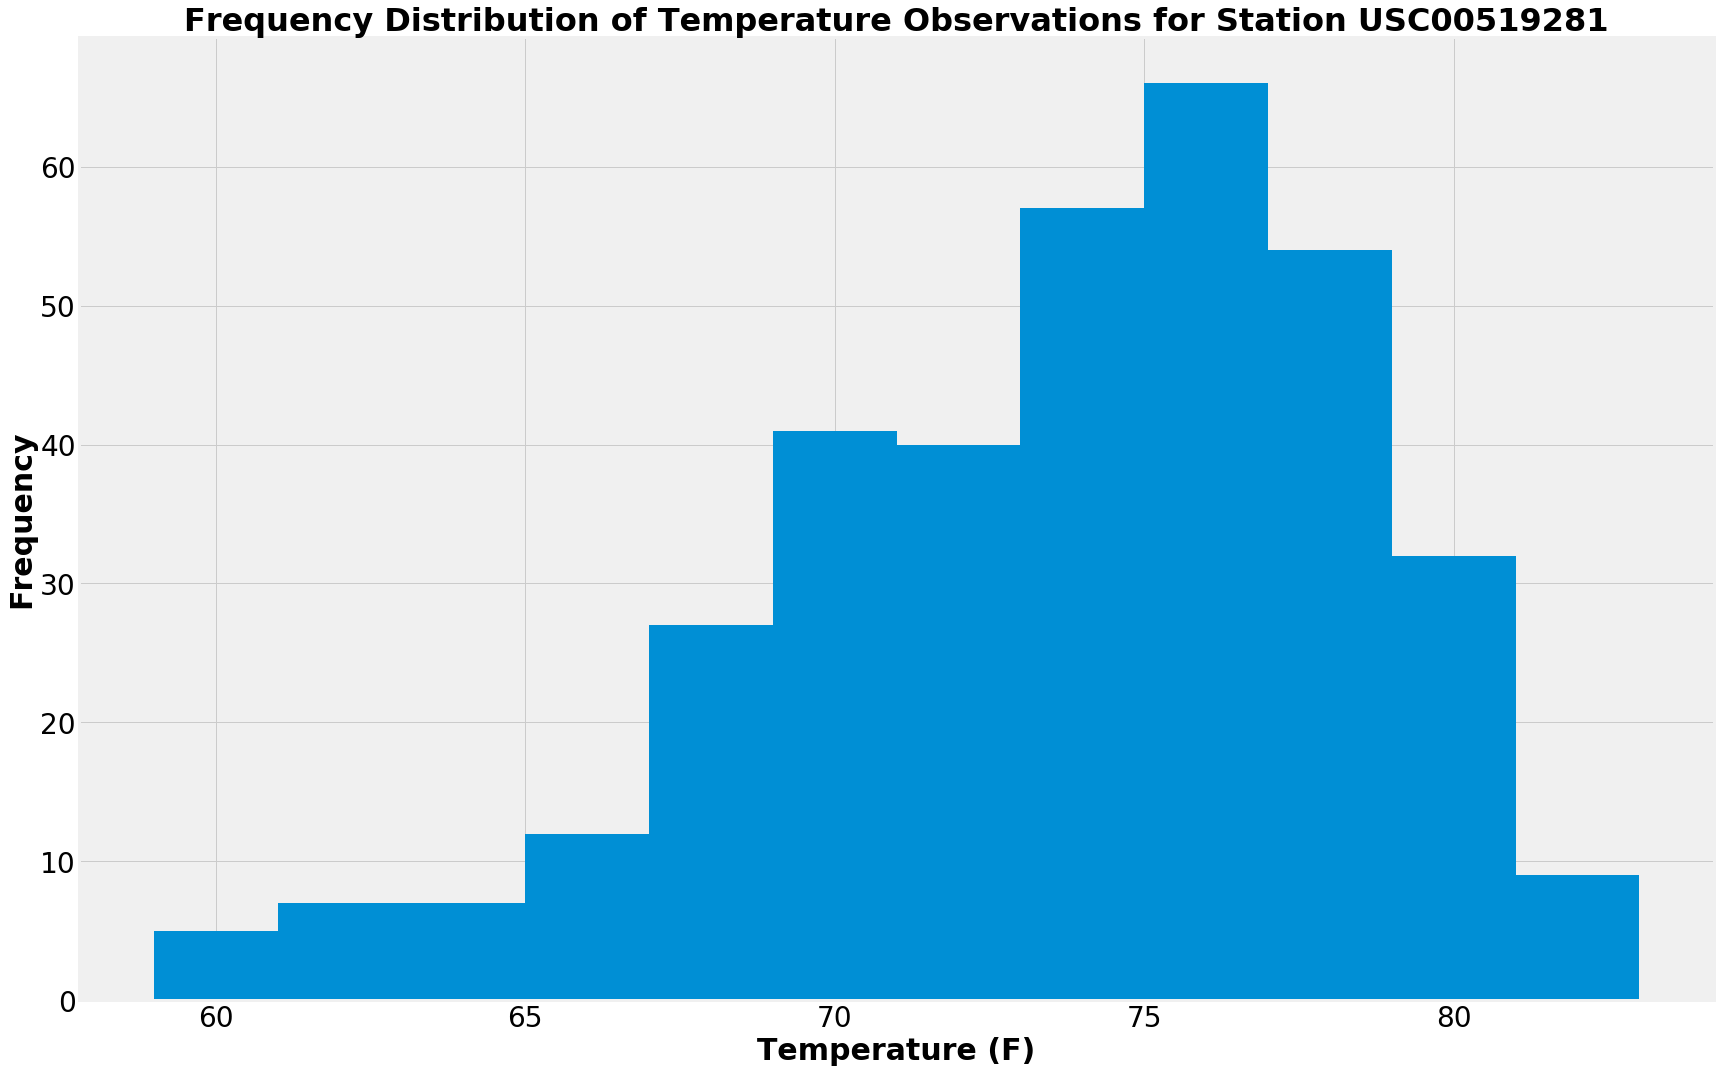

In [20]:
# Plot the results as a histogram

temps = busy_station['tobs']

fig, ax = plt.subplots(figsize=(24,15))

# Generating graph
plt.hist(temps, bins=12, align='mid')

# Editing tick marks
plt.tick_params(axis='both', labelsize=28)

# Adding title, labels to graph
plt.title(f"Frequency Distribution of Temperature Observations for Station {busiest_station}", fontsize=32, fontweight='bold')
plt.xlabel("Temperature (F)", fontsize=30, fontweight='bold')
plt.ylabel("Frequency", fontsize=30, fontweight='bold')

# Fitting to rame and diisplaying
plt.tight_layout()
plt.show()


# Optional Analyses

## Temperature Analysis I

In [21]:
# Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
from sqlalchemy import extract

juntp = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(extract('month', Measurement.date)== 6).statement
jun_temps = pd.read_sql(juntp, session.bind)

dectp = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(extract('month', Measurement.date)== 12).statement
dec_temps = pd.read_sql(dectp, session.bind)

jun_avg = jun_temps["tobs"].mean()
dec_avg = dec_temps["tobs"].mean()

print(f'The average temperature in June was {round(jun_avg, 2)}')
print(f"The average temperature in December was {round(dec_avg, 2)}")

The average temperature in June was 74.94
The average temperature in December was 71.04


In [22]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
import scipy.stats as stats

I would use an a paired t-test because the temperature observations are related. The observations can be paired because the same measure (temperature) is being taken from the same station.

The null hypothesis states that there is no significant difference between the mean temperatures in June and December. 

The first step for conducting a paired t-test will be to pair the observations by station. However, since the number of obserations vary within each year, I will calculate an average for each station for each year. 

In [24]:
#Split date column so can average on year
dec_dates = dec_temps["date"].str.split("-", expand=True)
dec_temps["year"] = dec_dates[0]
jun_dates = jun_temps["date"].str.split("-", expand=True)
jun_temps["year"] = jun_dates[0]

# Calculate average by year and station 
jun = jun_temps.groupby(["year", "station"], as_index=False).agg({"tobs": "mean"})
dec = dec_temps.groupby(["year", "station"], as_index=False).agg({"tobs": "mean"})

#Pair averages by station (merge)
paired = pd.merge(jun, dec, how="inner", on=['station', 'year'])
paired_temps = paired.rename(columns={"tobs_x": "Jun_tobs", "tobs_y": "Dec_tobs"})
paired_temps.head()

,year,station,Jun_tobs,Dec_tobs
0,2010,USC00511918,75.620690,70.000000
1,2010,USC00513117,74.800000,70.967742
2,2010,USC00514830,73.689655,69.233333
3,2010,USC00516128,72.863636,69.483871
4,2010,USC00517948,76.750000,69.500000


In [25]:
# t-test  
a_values = paired_temps["Jun_tobs"]
b_values = paired_temps["Dec_tobs"]
stats.ttest_rel(a_values, b_values)

Ttest_relResult(statistic=13.27434875934499, pvalue=8.635821572107224e-19)

#### Reject the null hypothesis. There is statistically significant difference between the average observed temperatures in June and December in Hawaii.

## Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacay_start = '2017-06-06'
vacay_end = '2017-06-18'
vacay_temps = calc_temps(vacay_start, vacay_end)
print(f'My vacation to Hawaii is from {vacay_start} to {vacay_end}')
print(vacay_temps)

My vacation to Hawaii is from 2017-06-06 to 2017-06-18
[(72.0, 77.10588235294118, 83.0)]


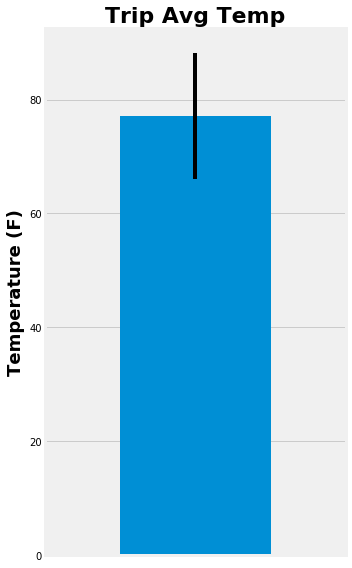

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacay_df = pd.DataFrame(vacay_temps, columns=['Min', 'Avg', 'Max'])
xvalue = 1
yvalue = vacay_df['Avg']
yerror = vacay_df['Max'] - vacay_df['Min']

fig, ax = plt.subplots(figsize=(5,8))
plt.bar(xvalue, yvalue, yerr=yerror, width=.5, align='center')

plt.xlim(.5,1.5)
plt.xticks([])

# Adding title, labels to graph
plt.title('Trip Avg Temp', fontsize=22, fontweight='bold')
plt.ylabel("Temperature (F)", fontsize=18, fontweight='bold')

# Fitting to rame and diisplaying
plt.tight_layout()
plt.show()


## Daily Rainfall Average

In [29]:
# Looking at the first row of the Station table to do a join
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b8074f2e48>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#session.query(Station).all()

# Join tables together and filter by vacay dates
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
query = session.query(*sel).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        filter(Measurement.date.between(vacay_start, vacay_end)).\
        order_by(func.sum(Measurement.prcp).desc()).all()

# Create dataframe of station details
station_rainfall = pd.DataFrame(query, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total_Precip'])
station_rainfall

,Station,Name,Latitude,Longitude,Elevation,Total_Precip
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.57
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.00
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.10
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.86
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.19
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
vacations = ["06-06", "06-07", "06-08", "06-09", 
            "06-10", "06-11", "06-12", "06-13", 
            "06-14", "06-15", "06-16", "06-17", "06-18"]

# Loop through the list of %m-%d strings and calculate the normals for each date
for vacation in vacations:
    normals.append(list(np.ravel(daily_normals(vacation))))


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_temps = pd.DataFrame(normals, columns=["Min", "Avg", "Max"])
daily_temps["Date"] = vacations
trip_temps = daily_temps.set_index("Date")
trip_temps

,Min,Avg,Max
Date,,,
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0
06-14,69.0,75.627119,81.0


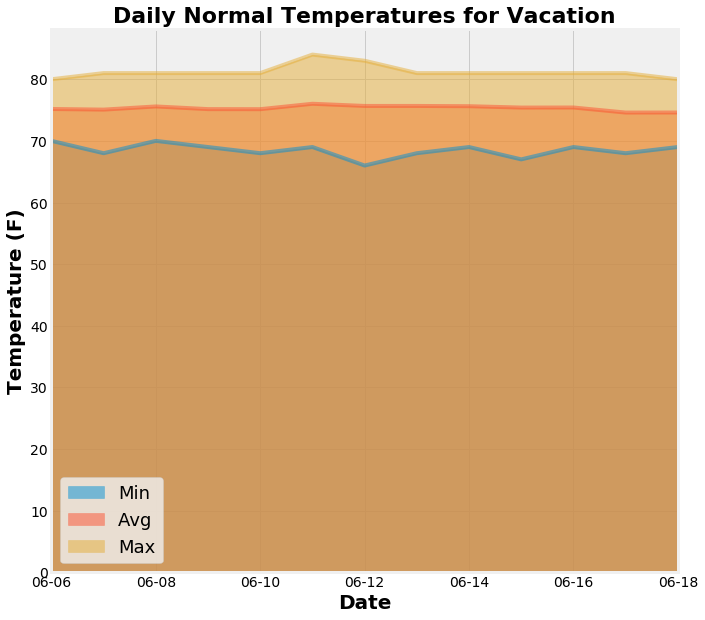

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
area = trip_temps.plot(kind="area", stacked=False, figsize=(10, 10), fontsize=14)

area.legend(prop={'size':18})
# Adding title, labels to graph
area.set_title("Daily Normal Temperatures for Vacation", fontsize=22, fontweight='bold')
area.set_xlabel("Date", fontsize=20, fontweight='bold')
area.set_ylabel("Temperature (F)", fontsize=20, fontweight='bold')

# Fitting to rame and diisplaying
#plt.tight_layout()
plt.show()
